<a href="https://colab.research.google.com/github/alexontour/snippets/blob/main/snip_fhir_create.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author: Alexander Kollmann, 08/2022**

---

**Funktion**

FHIR-Server ansprechen (HAPI)

FHIR - Ressorcen schreiben und verknüpfen (versch. Optionen)

Patient, Encounter, Observation, Condition

---



**Referenzen**

https://colab.research.google.com/drive/1OSuqqACnCqw8h67E7DKDMyIGO1C2qbEq?usp=sharing#scrollTo=rU-lfJob3fOf

---



In [1]:
import json
import requests
from collections import OrderedDict
from io import StringIO

In [2]:
# Base URL zum FHIR-Server
url = "http://hapi.fhir.org/baseR4/" # Open HAPI FHIR Server
#url = "https://server.fire.ly/R4/" # Open Firely Server

# Header definieren
headers = {"Content-Type": "application/fhir+json;charset=utf-8"}

Resource Patient: https://www.hl7.org/fhir/patient.html

Demographics and other administrative information about an individual or animal receiving care or other health-related services. This Resource covers data about patients and animals involved in a wide range of health-related activities.

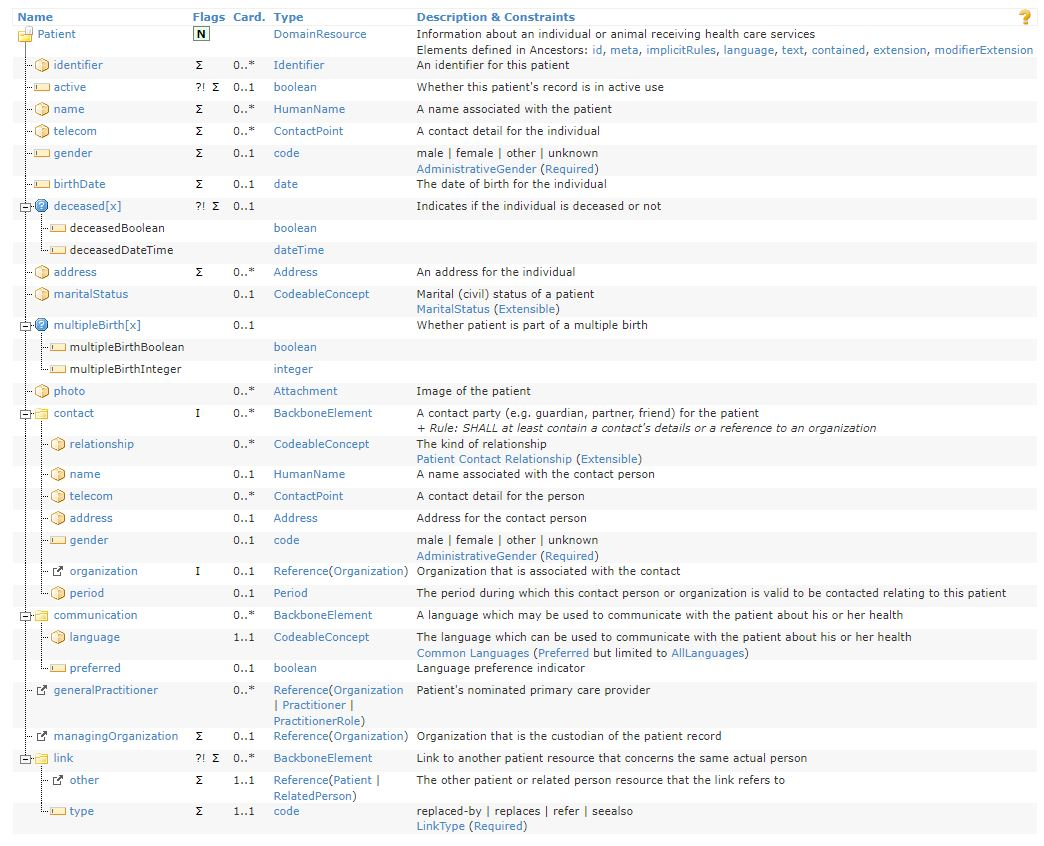

In [3]:
# Option 1: JSON - Ressouce erstellen lt. Datenmodell

patient = json.loads("""{
   "resourceType":"Patient",
   "name":[
      {
         "given": "Christiano",
         "family": "Ronaldo",
         "text":"Christiano Ronaldo",
         "use": "official"
      }
   ],
   "gender":"male",
   "birthDate":"1950-01-01"
}""")

In [6]:
# FHIR Ressource an FHIR-Server senden (POST)
response = requests.request("POST", url + "Patient", headers=headers, data=str(patient))

# Ergebnis (Response) verarbeiten
patient_id = json.loads(response.text)['id']
patient_name = json.loads(response.text)['name']
#response.json()

print("Patient-ID: " + patient_id)
#print(patient_name[0]['given'])

Patient-ID: 6998276


In [8]:
# Option 2: Erzeugen der FHIR-Ressource in eine Funktion auslagern
def create_patient():

    body = {
        "name":[
            {
              "given": "Christiano",
              "family": "Ronaldo",
              "text":"Christiano Ronaldo",
              "use": "official"
            }
        ],
        "birthDate":"1950-01-01",
        "gender": "male",
        "resourceType": "Patient",
    }

    io = StringIO()
    json.dump(body, io, indent=2)

    return io


In [9]:
# FHIR Ressource über Funktionsaufruf erstellen unn an FHIR-Server senden (POST)
response = requests.request("POST", url + "Patient", headers=headers, data=create_patient().getvalue())

patient_id = json.loads(response.text)['id']

print("Patient-ID: "+ patient_id)

Patient-ID: 6998277


Resource Encounter: https://www.hl7.org/fhir/encounter.html

A patient encounter is further characterized by the setting in which it takes place. Amongst them are ambulatory, emergency, home health, inpatient and virtual encounters. An Encounter encompasses the lifecycle from pre-admission, the actual encounter (for ambulatory encounters), and admission, stay and discharge (for inpatient encounters). During the encounter the patient may move from practitioner to practitioner and location to location.

In [10]:
def create_encounter(patient_id):

    body = {
        "status": "finished",
        "class": {
            "system": "http://hl7.org/fhir/v3/ActCode",
            "code": "IMP",
            "display": "inpatient encounter",
        },
        "reason": [
            {
                "text": "The patient had an abnormal heart rate. She was concerned about this."
            }
        ],
        "subject": {"reference": "Patient/{}".format(patient_id)},
        "resourceType": "Encounter",
    }

    io = StringIO()
    json.dump(body, io, indent=2)

    return io

response = requests.request("POST", url + "Encounter", headers=headers, data=create_encounter(patient_id).getvalue())

encounter_id = json.loads(response.text)['id']
#response.json()

print("Encounter-ID: " + encounter_id)

Encounter-ID: 6998278


Resource Observation: https://www.hl7.org/fhir/observation.html

Measurements and simple assertions made about a patient, device or other subject. Observations are a central element in healthcare, used to support diagnosis, monitor progress, determine baselines and patterns and even capture demographic characteristics.

In [11]:
def create_observation(patient_id,encounter_id):

    body = {
        "resourceType": "Observation",
        "code": {
            "coding": [
                {
                    "system": "http://loinc.org",
                    "code": "8867-4",
                    "display": "Heart rate",
                }
            ]
        },
        "status": "final",
        "subject": {"reference": "Patient/{}".format(patient_id)},
        "effectiveDateTime": "2019-01-01T00:00:00+00:00",
        "valueQuantity": {"value": 80, "unit": "bpm"},
        "context": {"reference": "Encounter/{}".format(encounter_id)},
    }

    io = StringIO()
    json.dump(body, io, indent=2)

    return io

response = requests.request("POST", url + "Observation", headers=headers, data=create_observation(patient_id,encounter_id).getvalue())

observation_id = json.loads(response.text)['id']
#response.json()

print("Observation-ID: " + observation_id)

Observation-ID: 6998279


Resource Condition: https://www.hl7.org/fhir/condition.html

A clinical condition, problem, diagnosis, or other event, situation, issue, or clinical concept that has risen to a level of concern. This resource is used to record detailed information about a condition, problem, diagnosis, or other event, situation, issue, or clinical concept that has risen to a level of concern.

In [14]:
# Option 3: FHIR-Ressource über Dictionary erstellen
problem = OrderedDict()
problem['resourceType'] = 'Condition'
#problem['id'] = 'example'
problem['patient'] = {"reference": "Patient/{}".format(patient_id)}
#problem['encounter'] = {'reference': 'Encounter/67890'}
problem['dateRecorded'] = '2021-04-01T13:00'
problem['code'] = {'coding':
                       [{'system': 'http://hl7.org/fhir/sid/icd-10-us',
                         'code': 'E10.65',
                         'display': 'Type 1 Diabetes Mellitus with Hyperglycemia'}]}
problem['clinicalStatus'] = "active"
problem['verificationStatus'] = 'provisional'

io = StringIO()
json.dump(problem, io, indent=2)
#print(io.getvalue())

response = requests.request("POST", url + "Condition", headers=headers, data=io.getvalue())

condition_id = json.loads(response.text)['id']
#response.json()

print("Condition-ID: " + condition_id)

Condition-ID: 6998282
